# SISTEM REKOMENDASI DESTINASI WISATA DI KOTA YOGYAKARTA MENGGUNAKAN COLLABORATIVE FILTERING

## Import Library

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(palette = 'Set1')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

import os

## Data Collecting

In [2]:
! kaggle datasets download -d aprabowo/indonesia-tourism-destination

with ZipFile("indonesia-tourism-destination.zip", 'r') as zip:
    zip.extractall("indonesia-tourism-destination")

Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
100% 158k/158k [00:00<00:00, 496kB/s]
100% 158k/158k [00:00<00:00, 496kB/s]


In [3]:
for dirname, _, filenames in os.walk('indonesia-tourism-destination'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

indonesia-tourism-destination/user.csv
indonesia-tourism-destination/tourism_rating.csv
indonesia-tourism-destination/tourism_with_id.csv
indonesia-tourism-destination/package_tourism.csv


## Data Understanding

In [4]:
# Inisialisasi variabel untuk menyimpan dataset
rating = pd.read_csv('/content/indonesia-tourism-destination/tourism_rating.csv')
place = pd.read_csv('/content/indonesia-tourism-destination/tourism_with_id.csv')
user =  pd.read_csv('/content/indonesia-tourism-destination/user.csv')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Place Data

In [6]:
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [7]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [8]:
# Check city the names of cities in the City variable
unique_cities = place['City'].unique()
print("City name:", unique_cities)

City name: ['Jakarta' 'Yogyakarta' 'Bandung' 'Semarang' 'Surabaya']


#### Rating Data

In [9]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [10]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


#### User Data

In [11]:
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [12]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


### Exploratory Data Analysis

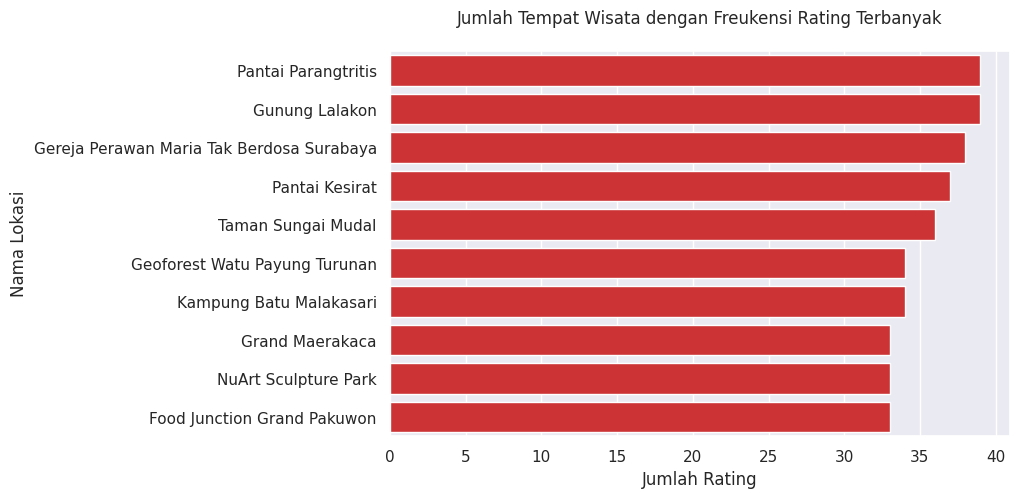

In [13]:
# Membuat data frame yang memuat wisata dengan frekuensi rating terbanyak
top_10 = rating['Place_Id'].value_counts().reset_index()[0:10]
top_10.columns = ['Place_Id', 'count']
top_10 = pd.merge(top_10, place[['Place_Id', 'Place_Name', 'City']], how='left', on='Place_Id')

# Visualisasi wisata dengan frekuensi rating terbanyak
plt.figure(figsize=(8, 5))
sns.barplot(x='count', y='Place_Name', data=top_10)
plt.title('Jumlah Tempat Wisata dengan Freukensi Rating Terbanyak', pad=20)
plt.ylabel('Nama Lokasi')
plt.xlabel('Jumlah Rating')
plt.show()

In [14]:
top_10_with_city = top_10[['Place_Name', 'City']]
print(top_10_with_city)

                                  Place_Name        City
0                        Pantai Parangtritis  Yogyakarta
1                             Gunung Lalakon     Bandung
2  Gereja Perawan Maria Tak Berdosa Surabaya    Surabaya
3                             Pantai Kesirat  Yogyakarta
4                         Taman Sungai Mudal  Yogyakarta
5              Geoforest Watu Payung Turunan  Yogyakarta
6                    Kampung Batu Malakasari     Bandung
7                            Grand Maerakaca    Semarang
8                       NuArt Sculpture Park     Bandung
9                Food Junction Grand Pakuwon    Surabaya


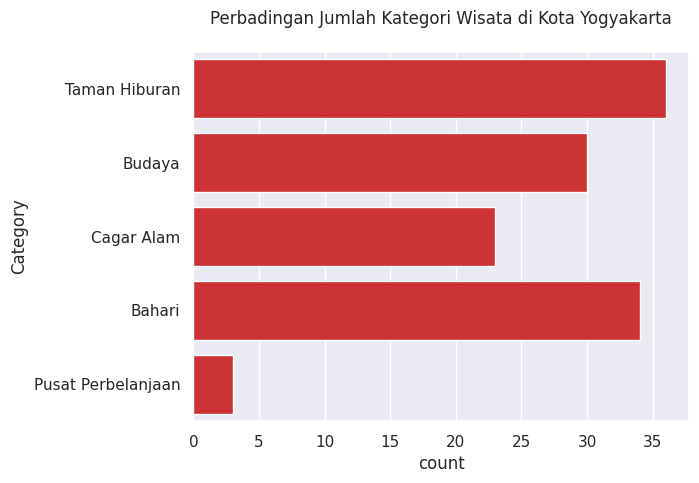

In [15]:
# Visualisasi jumlah kategori wisata di Kota Yogyakarta
sns.countplot(y='Category', data=place[place['City'] == 'Yogyakarta'])
plt.title('Perbadingan Jumlah Kategori Wisata di Kota Yogyakarta', pad=20)
plt.show()

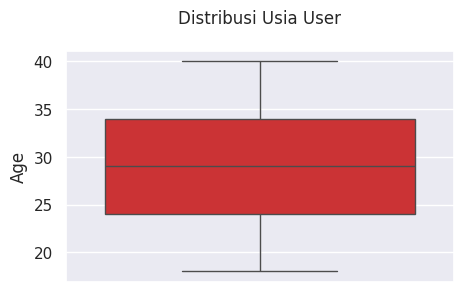

In [16]:
# Visualisasi distribusi dari usia user
plt.figure(figsize=(5, 3))
sns.boxplot(user['Age'])
plt.title('Distribusi Usia User', pad=20)
plt.show()

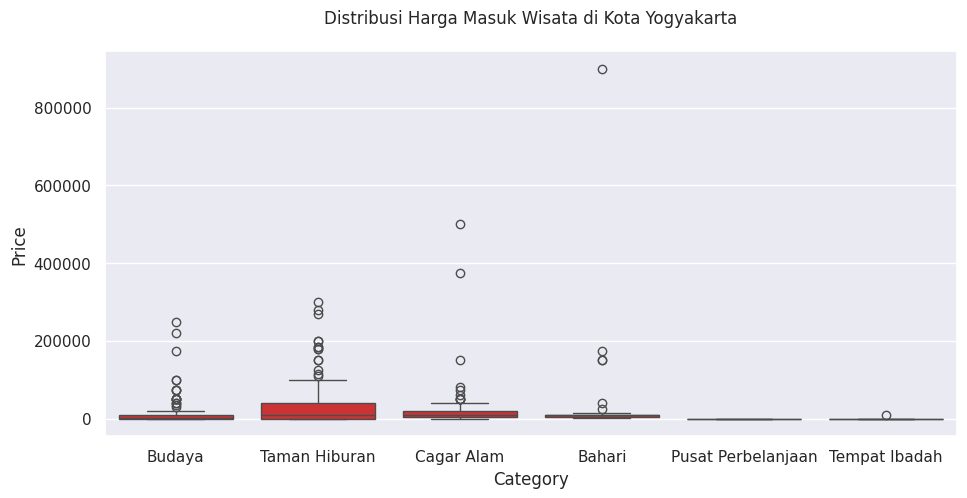

In [17]:
# Visualisasi distribusi harga masuk wisata di kota Yogyakarta
plt.figure(figsize=(11, 5))
sns.boxplot(x='Category', y='Price', data=place)
plt.title('Distribusi Harga Masuk Wisata di Kota Yogyakarta', pad=20)
plt.show()

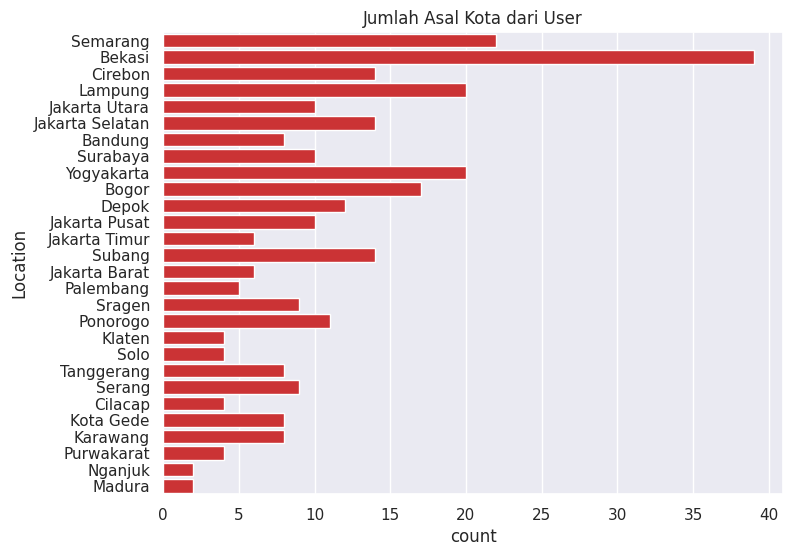

In [18]:
# Memfilter asal kota dari user
asal = user['Location'].apply(lambda x : x.split(',')[0])

# Visualisasi asal kota dari user
plt.figure(figsize=(8, 6))
sns.countplot(y=asal)
plt.title('Jumlah Asal Kota dari User')
plt.show()

## Data Preparation

In [19]:
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [20]:
# Menghapus kolom yang tidak digunakan
place = place.drop(['Unnamed: 11',	'Unnamed: 12', 'Time_Minutes'], axis=1)
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


In [21]:
# Hanya menggunakan data wisata pada kota Yogyakarta
place = place[place['City']=='Yogyakarta']
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Coordinate,Lat,Long
84,85,Taman Pintar Yogyakarta,Taman Pintar Yogyakarta (bahasa Jawa: Hanacara...,Taman Hiburan,Yogyakarta,6000,4.5,"{'lat': -7.800671500000001, 'lng': 110.3676551}",-7.800671,110.367655
85,86,Keraton Yogyakarta,Keraton Ngayogyakarta Hadiningrat atau Keraton...,Budaya,Yogyakarta,15000,4.6,"{'lat': -7.8052845, 'lng': 110.3642031}",-7.805284,110.364203
86,87,Sindu Kusuma Edupark (SKE),Sindu Kusuma Edupark (SKE) merupakan sebuah de...,Taman Hiburan,Yogyakarta,20000,4.2,"{'lat': -7.767297300000001, 'lng': 110.3542486}",-7.767297,110.354249
87,88,Museum Benteng Vredeburg Yogyakarta,Museum Benteng Vredeburg (bahasa Jawa: ꦩꦸꦱꦶꦪꦸꦩ...,Budaya,Yogyakarta,3000,4.6,"{'lat': -7.800201599999999, 'lng': 110.3663044}",-7.800202,110.366304
88,89,De Mata Museum Jogja,Museum De Mata merupakan salah satu museum yan...,Budaya,Yogyakarta,50000,4.4,"{'lat': -7.816315599999999, 'lng': 110.3871442}",-7.816316,110.387144


In [22]:
# Mengubah rating agar hanya berisi rating pada kota Yogyakarta
# Gabungkan 2 data frame yaitu rating dan place berdasarkan kolom 'Place_Id'
rating = pd.merge(rating, place[['Place_Id']], how='right', on='Place_Id')
rating.head()

,User_Id,Place_Id,Place_Ratings
0,2,85,4
1,23,85,4
2,25,85,2
3,39,85,5
4,43,85,4


In [23]:
# Mengubah rating agar hanya berisi wisatawan pada kota Yogyakarta
# Gabungkan 2 data frame yaitu user dan rating berdasarkan kolom 'User_Id', serta menghapus dupilkat
user = pd.merge(user, rating[['User_Id']], how='right', on='User_Id')
user.drop_duplicates().sort_values('User_Id')
user.head()

,User_Id,Location,Age
0,2,"Bekasi, Jawa Barat",21
1,23,"Jakarta Barat, DKI Jakarta",37
2,25,"Lampung, Sumatera Selatan",40
3,39,"Cilacap, Jawa Tengah",32
4,43,"Cirebon, Jawa Barat",33


### Encoding

In [24]:
# Membaca dataset untuk dilakukan encoding
df = rating.copy()
df.head()

,User_Id,Place_Id,Place_Ratings
0,2,85,4
1,23,85,4
2,25,85,2
3,39,85,5
4,43,85,4


In [25]:
# Membuat fungsi untuk encoding
def dict_encoder(col, data=df):
  unique_val = data[col].unique().tolist()

  val_to_val_encoded = { x: i for i, x in enumerate(unique_val)}

  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [26]:
# Encoding and Mapping pada kolom user
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')

df['user'] = df['User_Id'].map(user_to_user_encoded)

print('Mapping dari User_Id ke nilai terenkripsi')
print(user_to_user_encoded)
print('/nMapping dari nilai terenkripsi keembali User_Id')
print(user_encoded_to_user)
print('/nDataframe setelah encoding')
print(pd.DataFrame(df))

Mapping dari User_Id ke nilai terenkripsi
{2: 0, 23: 1, 25: 2, 39: 3, 43: 4, 52: 5, 60: 6, 68: 7, 72: 8, 74: 9, 88: 10, 93: 11, 104: 12, 132: 13, 140: 14, 157: 15, 159: 16, 165: 17, 182: 18, 233: 19, 247: 20, 262: 21, 269: 22, 276: 23, 282: 24, 3: 25, 31: 26, 38: 27, 40: 28, 96: 29, 105: 30, 109: 31, 121: 32, 134: 33, 138: 34, 162: 35, 167: 36, 171: 37, 219: 38, 231: 39, 248: 40, 257: 41, 259: 42, 279: 43, 289: 44, 294: 45, 70: 46, 92: 47, 142: 48, 160: 49, 181: 50, 184: 51, 189: 52, 199: 53, 208: 54, 211: 55, 226: 56, 271: 57, 281: 58, 290: 59, 4: 60, 6: 61, 7: 62, 11: 63, 14: 64, 18: 65, 21: 66, 41: 67, 44: 68, 64: 69, 79: 70, 91: 71, 100: 72, 107: 73, 154: 74, 186: 75, 193: 76, 204: 77, 207: 78, 243: 79, 256: 80, 258: 81, 265: 82, 292: 83, 297: 84, 1: 85, 8: 86, 16: 87, 46: 88, 50: 89, 55: 90, 58: 91, 67: 92, 101: 93, 126: 94, 136: 95, 148: 96, 155: 97, 190: 98, 198: 99, 214: 100, 222: 101, 286: 102, 295: 103, 10: 104, 15: 105, 20: 106, 28: 107, 49: 108, 102: 109, 103: 110, 112: 111

In [27]:
# Encoding and Mapping pada kolom place
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

df['place'] = df['Place_Id'].map(place_to_place_encoded)

print('Mapping dari Place_Id ke nilai terenkripsi')
print(place_to_place_encoded)
print('/nMapping dari nilai terenkripsi keembali Place_Id')
print(place_encoded_to_place)
print('/nDataframe setelah encoding')
print(pd.DataFrame(df))

Mapping dari Place_Id ke nilai terenkripsi
{85: 0, 86: 1, 87: 2, 88: 3, 89: 4, 90: 5, 91: 6, 92: 7, 93: 8, 94: 9, 95: 10, 96: 11, 97: 12, 98: 13, 99: 14, 100: 15, 101: 16, 102: 17, 103: 18, 104: 19, 105: 20, 106: 21, 107: 22, 108: 23, 109: 24, 110: 25, 111: 26, 112: 27, 113: 28, 114: 29, 115: 30, 116: 31, 117: 32, 118: 33, 119: 34, 120: 35, 121: 36, 122: 37, 123: 38, 124: 39, 125: 40, 126: 41, 127: 42, 128: 43, 129: 44, 130: 45, 131: 46, 132: 47, 133: 48, 134: 49, 135: 50, 136: 51, 137: 52, 138: 53, 139: 54, 140: 55, 141: 56, 142: 57, 143: 58, 144: 59, 145: 60, 146: 61, 147: 62, 148: 63, 149: 64, 150: 65, 151: 66, 152: 67, 153: 68, 154: 69, 155: 70, 156: 71, 157: 72, 158: 73, 159: 74, 160: 75, 161: 76, 162: 77, 163: 78, 164: 79, 165: 80, 166: 81, 167: 82, 168: 83, 169: 84, 170: 85, 171: 86, 172: 87, 173: 88, 174: 89, 175: 90, 176: 91, 177: 92, 178: 93, 179: 94, 180: 95, 181: 96, 182: 97, 183: 98, 184: 99, 185: 100, 186: 101, 187: 102, 188: 103, 189: 104, 190: 105, 191: 106, 192: 107, 1

### See on Overview of the Data Modelling

In [28]:
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)

df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

print(f'Number of User: {num_users}, Number of Place: {num_place}, Min Rating: {min_rating}, Max Rating:')

Number of User: 300, Number of Place: 126, Min Rating: 1.0, Max Rating:


In [29]:
# Mengecek dataset
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,Place_Id,Place_Ratings,user,place
729,194,115,4.0,130,30
2067,276,176,2.0,23,91
1288,197,142,5.0,148,57
1738,247,162,3.0,20,77
2078,109,177,2.0,31,92


## Modeling Machine Learning using RecommenderNet

### Split Data into Train and Test Data

In [30]:
# Inisialisasi var x untuk mencocokkan data user dan place menjadi 1 value
x = df[['user', 'place']].values

# Inisialisasi var y untuk membuat rating dari hasil
y = df['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data test
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

### Function Initialization

In [31]:
class RecommenderNet(tf.keras.Model):

  # Inisialisasi fungsi
  def __init__(self, num_users, num_places, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.places_embedding = layers.Embedding(
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.places_bias = layers.Embedding(num_places, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    places_vector = self.places_embedding(inputs[:,1])
    places_bias = self.places_bias(inputs[:,1])

    dot_user_places = tf.tensordot(user_vector, places_vector, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x)

### Model Initialization

In [32]:
model = RecommenderNet(num_users, num_place, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

### Callbacks Initialization

In [33]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_root_mean_squared_error')<0.25):
      print('Lapor! Metriks validasi sudah sesuai harapan')
      self.model.stop_training = True

### Training Model

In [34]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks = [myCallback()]
)

Epoch 1/100
72/72 [==============================] - 3s 14ms/step - loss: 0.7149 - root_mean_squared_error: 0.3655 - val_loss: 0.7286 - val_root_mean_squared_error: 0.3648
Epoch 2/100
72/72 [==============================] - 1s 7ms/step - loss: 0.7164 - root_mean_squared_error: 0.3666 - val_loss: 0.7284 - val_root_mean_squared_error: 0.3647
Epoch 3/100
72/72 [==============================] - 1s 7ms/step - loss: 0.7072 - root_mean_squared_error: 0.3606 - val_loss: 0.7294 - val_root_mean_squared_error: 0.3654
Epoch 4/100
72/72 [==============================] - 0s 6ms/step - loss: 0.7033 - root_mean_squared_error: 0.3582 - val_loss: 0.7294 - val_root_mean_squared_error: 0.3653
Epoch 5/100
72/72 [==============================] - 0s 7ms/step - loss: 0.7023 - root_mean_squared_error: 0.3574 - val_loss: 0.7295 - val_root_mean_squared_error: 0.3655
Epoch 6/100
72/72 [==============================] - 0s 5ms/step - loss: 0.7051 - root_mean_squared_error: 0.3592 - val_loss: 0.7285 - val_root_

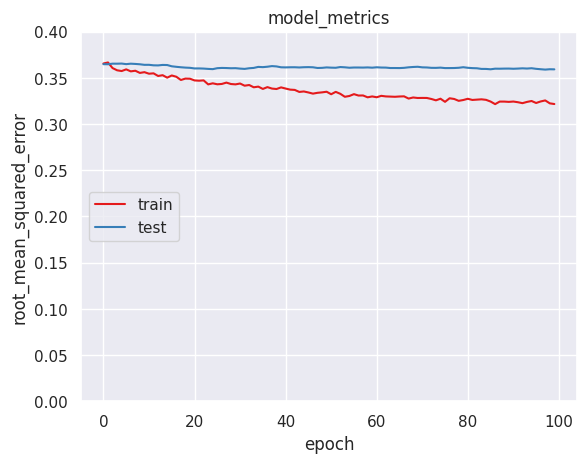

In [35]:
# Menampilkan plot loss dan validation
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

## Predict Top 7 Recommendation

In [36]:
# Menyiapkan dataframe
place_df = place[['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price']]
place_df.columns = ['id', 'place_name', 'category', 'rating', 'price']
df = rating.copy()

In [37]:
# Menamgbil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [38]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id']
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [39]:
# Mengambil top 7 rekomendasi
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-7:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]

print('Daftar rekomendasi destinasi wisata di Kota Yogyakarta untuk: {}'.format('User' + str(user_id)))
print('===' * 15, '\n')
print('----' * 15)
print('Tempat dengan rating wisata paling tinggi dari user')
print('----' * 15)

top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head()
    .Place_Id.values
)

place_df_rows = place_df[place_df['id'].isin(top_place_user)]
for row in place_df_rows.itertuples():
  print(row.place_name, ':', row.category)

print('')
print('----' * 15)
print('Top 7 place recommendation')
print('----' * 15)

recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for i, row in recommended_place.iterrows():
  print(i, '-', row.place_name, '\n', row.category, ',', 'Harga Tiket Masuk', row.price, ',', 'Rating Wisata', row.rating, '\n')

print('---' *15)

4/4 [==============================] - 0s 4ms/step
Daftar rekomendasi untuk: User117

------------------------------------------------------------
Tempat dengan rating wisata paling tinggi dari user
------------------------------------------------------------
Monumen Batik Yogyakarta : Budaya
Bukit Lintang Sewu : Taman Hiburan
Air Terjun Kedung Pedut : Cagar Alam
Hutan Pinus Asri : Cagar Alam
Green Village Gedangsari : Taman Hiburan

------------------------------------------------------------
Top 7 place recommendation
------------------------------------------------------------
156 - Pantai Baron 
 Bahari , Harga Tiket Masuk 10000 , Rating Wisata 4.4 

163 - Pintoe Langit Dahromo 
 Cagar Alam , Harga Tiket Masuk 2500 , Rating Wisata 4.4 

193 - Pantai Wediombo 
 Bahari , Harga Tiket Masuk 5000 , Rating Wisata 4.5 

195 - Pantai Ngrenehan 
 Bahari , Harga Tiket Masuk 3000 , Rating Wisata 4.4 

201 - Pantai Ngandong 
 Bahari , Harga Tiket Masuk 10000 , Rating Wisata 4.5 

207 - Taman S